### This notebook visualizes ground truth on main images

In [1]:
from PIL import Image,ImageDraw
import json
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import matplotlib.image as mpimg
from math import floor

from urllib.parse import urlparse
import urllib.request, json
import requests
from io import BytesIO
import os
Image.MAX_IMAGE_PIXELS = None

import boto3
import datetime
import json
import pandas as pd
import os
from pathlib import Path
import glob

### Thie function is for parsing string values with square brackets with multiple location entries for each image from csv files.

In [2]:
def stringToList(string):
    # input format : "[42, 42, 42]" , note the spaces after the commas, in this case I have a list of integers
    string = string[1:len(string)-1]
    if len(string) != 0: 
        tempList = string.split(", ")
        #print(tempList)
        tlist = [t.replace("'","").replace("[","").replace("]","") for t in tempList]
        #print(tlist)
        newList = list(map(lambda x: [int(y.replace("'","").replace("[","").replace("]","")) for y in x.split(",")], tempList))
    else:
        newList = ''
    return(newList)

In [3]:
def stringlistToList(string):
    string = string[0:len(string)]
    if len(string) != 0: 
        tempList = string.split(", ")
    return tempList

### Generate tolerance radii for each classes

In [4]:
gsd = 0.125
image_sizes = {"0001_0001":(24174,11141),"0001_0002":(23314,13134)}
decision_boundaries = {"bus": 1.5, "small":0.9, "specialized":1.7,"truck":1.4,"trailer_large":1.5,"trailer_small":1.1, "van_rv":1.3}
boundaries = np.array(list(decision_boundaries.values()))
values = np.divide(boundaries,gsd)
radii = {}
for k,v in zip(list(decision_boundaries.keys()),values):
    radii[k] = int(v)
class_sizes = {'bus':171, 'van_rv':127, 'small':101, 'specialized':111, 'truck':223, 'trailer_large':219, 'trailer_small':101, 'unknown':127}
values, radii, class_sizes,

(array([12. ,  7.2, 13.6, 11.2, 12. ,  8.8, 10.4]),
 {'bus': 12,
  'small': 7,
  'specialized': 13,
  'truck': 11,
  'trailer_large': 12,
  'trailer_small': 8,
  'van_rv': 10},
 {'bus': 171,
  'van_rv': 127,
  'small': 101,
  'specialized': 111,
  'truck': 223,
  'trailer_large': 219,
  'trailer_small': 101,
  'unknown': 127})

###  Load short ansswers csv file (Ground truth for just this one batch)

In [5]:
p = os.path.join(r'C:\Users\exx\Documents\lab\code\identification\notebooks\batch100_HITs\results\shortanswers.csv')

In [6]:
import ast
generic = lambda x: ast.literal_eval(x)
from ast import literal_eval
conv = {'# of vehicles':int,'truck':stringToList,'small':stringToList,'specialized':stringToList,'trailer_small':stringToList,'vehicle_types':stringlistToList}
df = pd.read_csv(p, converters =conv)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Unnamed: 0     20 non-null     int64 
 1   # of vehicles  20 non-null     int64 
 2   vehicle_types  20 non-null     object
 3   truck          20 non-null     object
 4   small          20 non-null     object
 5   specialized    20 non-null     object
 6   trailer_small  20 non-null     object
dtypes: int64(2), object(5)
memory usage: 1.2+ KB


### Class wise locations from main image

In [8]:
b = df[df['truck'] != '']['truck'].tolist()

In [9]:
trucks = df[df['truck'] != '']['truck'].tolist()
small = df[df['small'] != '']['small'].tolist()
specialized = df[df['specialized'] != '']['specialized'].tolist()
trailer_small = df[df['trailer_small'] != '']['trailer_small'].tolist()
l = [trucks[:1],  specialized[:1],trailer_small[:1]] #small[:1],
l

[[[[4999, 13026]]], [[[3795, 7592]]], [[[6387, 6527]]]]

### Locate class-wise locations on main images that have cropped slices

(4988, 13015, 5010, 13037) (24174, 11141) 11
(3782, 7579, 3808, 7605) (24174, 11141) 13
(6379, 6519, 6395, 6535) (24174, 11141) 8


Text(0.5, 1.0, '0001_0001 Image Vehicle Locations')

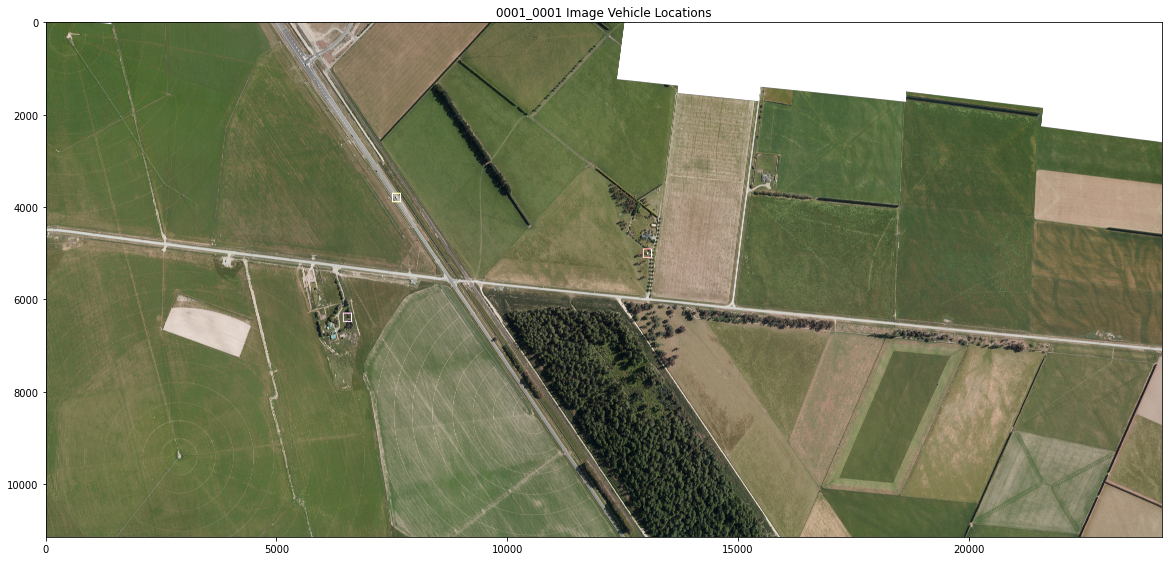

In [11]:
rad = []
import matplotlib.pyplot as plt
from matplotlib.patches import Circle,Rectangle
from copy import copy
import itertools
import matplotlib.colors

# Color for False and True
cmap = matplotlib.colors.ListedColormap(['black'])

#img = np.random.random(size=(11141,24174))
#rows, cols = np.ogrid[:img.shape[0], :img.shape[1]]

#img = Image.new("RGB", (24174,11141), (0, 0, 0))
#pimg = Image.fromarray(img.astype('uint8'), 'RGB')

# load main image
img = Image.open(r'C:\Users\exx\Documents\lab\LINZ\Final\001_selwyn-0125m-urban-aerial-photos-2012-2013\0001\0001\0001_0001_image.png')
draw = ImageDraw.Draw(img)
cols = itertools.cycle([(255,0,0,0),(255,255,0,0),(202, 44, 146,0)])

# for each location, class pair of values, draw bounding boxes. 3 vehicles from each of classes are cropped from this image : 'truck','specialized','trailer_small'
for locations,class_name in zip(l,['truck','specialized','trailer_small']):
    #locations are stored [[x1,x2...],[y1,y2,y3...]], get coordinate pairs (x_i,y_i)
    if locations and len(locations[0]) > 2:
        #print(len(locations[0]), locations[0][:2], locations[0][2:4])
        locs = [locations[0][i:i+2] for i in range(0,len(locations[0]),2)]
        print("locs",locs)
        locations = locs
    elif len(locations) == 1:
        locations = locations[0]
    xy = np.array(locations, dtype='int')
    np.random.seed(2018)

    local_sum = []
    radius = radii[class_name]
    rad.append(radius)
    
    #draw bounding boxes
    for row, col in xy:
        #mask = np.sqrt((rows - row)**2 + (cols - col)**2) <= radius
        #local_sum.append(np.sum(mask*img))
        print((row-radius, col-radius, row+radius, col+radius),img.size,radius)
        size = class_sizes[class_name]//2
        draw.rectangle(( col-100,row-100,  col+100,row+100,),outline=next(cols), width=20)

    #ax.imshow(img,cmap=cmap)
    #for i, [row, col] in enumerate(xy):
        #ax.add_patch(Circle((col, row), radius=75, color='red'))
        #ax.add_patch(Rectangle((col+size, row+size),class_sizes[class_name],class_sizes[class_name], color='red',fill=None))
        #plt.text(col, row, '{:.2f}'.format(local_sum[i]), ha='center', va='center')
img.convert('RGB').save("0001_0001_locations.png")
w,h = img.size
plt.figure(figsize=(20, 20))
plt.imshow(np.asarray(img))
plt.title("0001_0001 Image Vehicle Locations")
#plt.show(fig)
#plt.savefig("0001_001_locations.png")

In [12]:
trucks = df[df['truck'] != '']['truck'].tolist()
small = df[df['small'] != '']['small'].tolist()
trailer_small = df[df['trailer_small'] != '']['trailer_small'].tolist()
l = [trucks[1:], small,trailer_small[1:]]
for i,ll in enumerate(l):
    print(ll)
l = [ [[10055, 10674]], [[6167, 2158], [6146, 2157], [4115, 22594], [3878, 5212]], [[9660, 9771],[ 9266, 9199]]]
l

[[[10055, 10674]]]
[[[6167, 2158, 6146, 2157]], [[4115, 22594]], [[3878, 5212]], [[9660, 9771, 9266, 9199]]]
[[[5583, 10386]], [[3813, 5101]]]


[[[10055, 10674]],
 [[6167, 2158], [6146, 2157], [4115, 22594], [3878, 5212]],
 [[9660, 9771], [9266, 9199]]]

Text(0.5, 1.0, '0001_0002 Image Vehicle Locations')

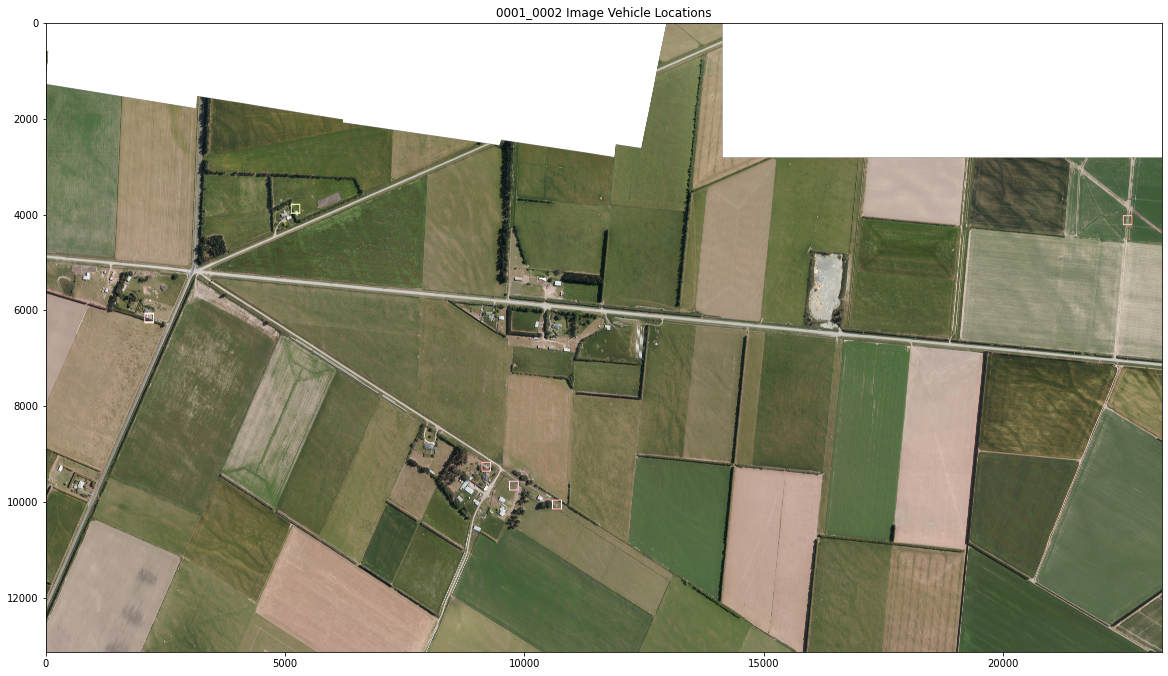

In [14]:
rad = []
import matplotlib.pyplot as plt
from matplotlib.patches import Circle,Rectangle
from copy import copy
import itertools

import matplotlib.colors

# Color for False and True
cmap = matplotlib.colors.ListedColormap(['black'])
#img = Image.new("RGB", (23314,13134), (0, 0, 0))

# load main image
img = Image.open(r'C:\Users\exx\Documents\lab\LINZ\Final\001_selwyn-0125m-urban-aerial-photos-2012-2013\0001\0002\0001_0002_image.png')
draw = ImageDraw.Draw(img)
cols = itertools.cycle([(255,0,0,0),(255,255,0,0),(202, 44, 146,0)])

# for each location, class pair of values, draw bounding boxes. 3 vehicles from each of classes are cropped from this image : 'truck','specialized','trailer_small'
for locations,class_name in zip(l,['truck','small','trailer_small']): #,'trailer_small']):
    #print(len(locations))
#     if len(locations) > 2:
#         #print(len(locations[0]), locations[0][:2], locations[0][2:4])
#         locs = [locations[0][0][i:i+2] for i in range(0,len(locations[0][0]),2)]
#         print("locs",locs)
#         locations = locs
#     else:
#         locations = locations[0]
    xy = np.array(locations, dtype='int')
    #print(xy.tolist())
    np.random.seed(2018)

    local_sum = []
    radius = radii[class_name]
    rad.append(radius)
    #print(radii[class_name])
    R,G,B = [(255,0,0,0),(0,255,0,0),(0,0,255,0)]
    for row, col in xy.tolist():
        size = class_sizes[class_name]//2
        draw.rectangle(( col-100,row-100,  col+100,row+100,),outline=next(cols), width=17)
img.convert('RGB').save("0001_0002_locations.png")
w,h = img.size
plt.figure(figsize=(20, 20))
plt.imshow(np.asarray(img))
plt.title("0001_0002 Image Vehicle Locations")    

In [16]:
rootpath = Path(os.getcwd())
output_path = os.path.join(rootpath,"batch100_HITs","results")
results_path = os.path.join(rootpath,"batch100_HITs","batch_results")

In [17]:
files = os.listdir(results_path)
files

['Batch_4408635_batch_results.csv']

In [18]:
df = pd.read_csv(os.path.join(results_path,files[0]))

In [19]:
submitted_answers = df[['HITId','Answer.taskAnswers', 'WorkerId', 'WorkTimeInSeconds', 'LifetimeApprovalRate','Approve', 'Reject']]

In [20]:
workers = list(submitted_answers.groupby(['WorkerId']).groups.keys())
len(workers)

5

In [21]:
hitids = list(submitted_answers.groupby(['HITId']).groups.keys())
len(hitids)

1

In [22]:
w = submitted_answers.loc[submitted_answers['WorkerId'] == workers[0]]
i = w.index[0]
#json.loads(w['Answer.taskAnswers'][i])

In [23]:
worker_scores = []
workers_scores = []
scores = 0
file = os.path.join(output_path,"original","answers.csv")
import pandas as pd
import ast
generic = lambda x: ast.literal_eval(x)
from ast import literal_eval
conv = {'# of vehicles':int,'truck':stringToList,'small':stringToList,'specialized':stringToList,'trailer_small':stringToList,'vehicle_types':stringlistToList}
answers = pd.read_csv(file, converters =conv)#,quotechar="'",sep=',') #dtype={'# of vehicles': int, 'truck':list}) #quotechar=''', sep=',',  converters={1:ast.literal_eval})
#print(answers.info(),answers.head())
image_locations = []
#df = rows[truck] = rows['truck'].apply(lambda x: stringToList(x))

import matplotlib.colors

# Color for False and True
cmap = matplotlib.colors.ListedColormap(['black'])

worker_answers = submitted_answers.loc[submitted_answers['WorkerId'] == workers[0]]
index = worker_answers.index[0]
tot_vehicles = 0

#img1 = Image.new("RGB", (24174,11141), (0, 0, 0))

image1 = Image.open(r'C:\Users\exx\Documents\lab\LINZ\Final\001_selwyn-0125m-urban-aerial-photos-2012-2013\0001\0001\0001_0001_image.png')

cols = itertools.cycle([(255,0,0,0),(255,255,0,0),(202, 44, 146,0)])

#img2 = Image.new("RGB", (23314,13134), (0, 0, 0))
image2 = Image.open(r'C:\Users\exx\Documents\lab\LINZ\Final\001_selwyn-0125m-urban-aerial-photos-2012-2013\0001\0002\0001_0002_image.png')

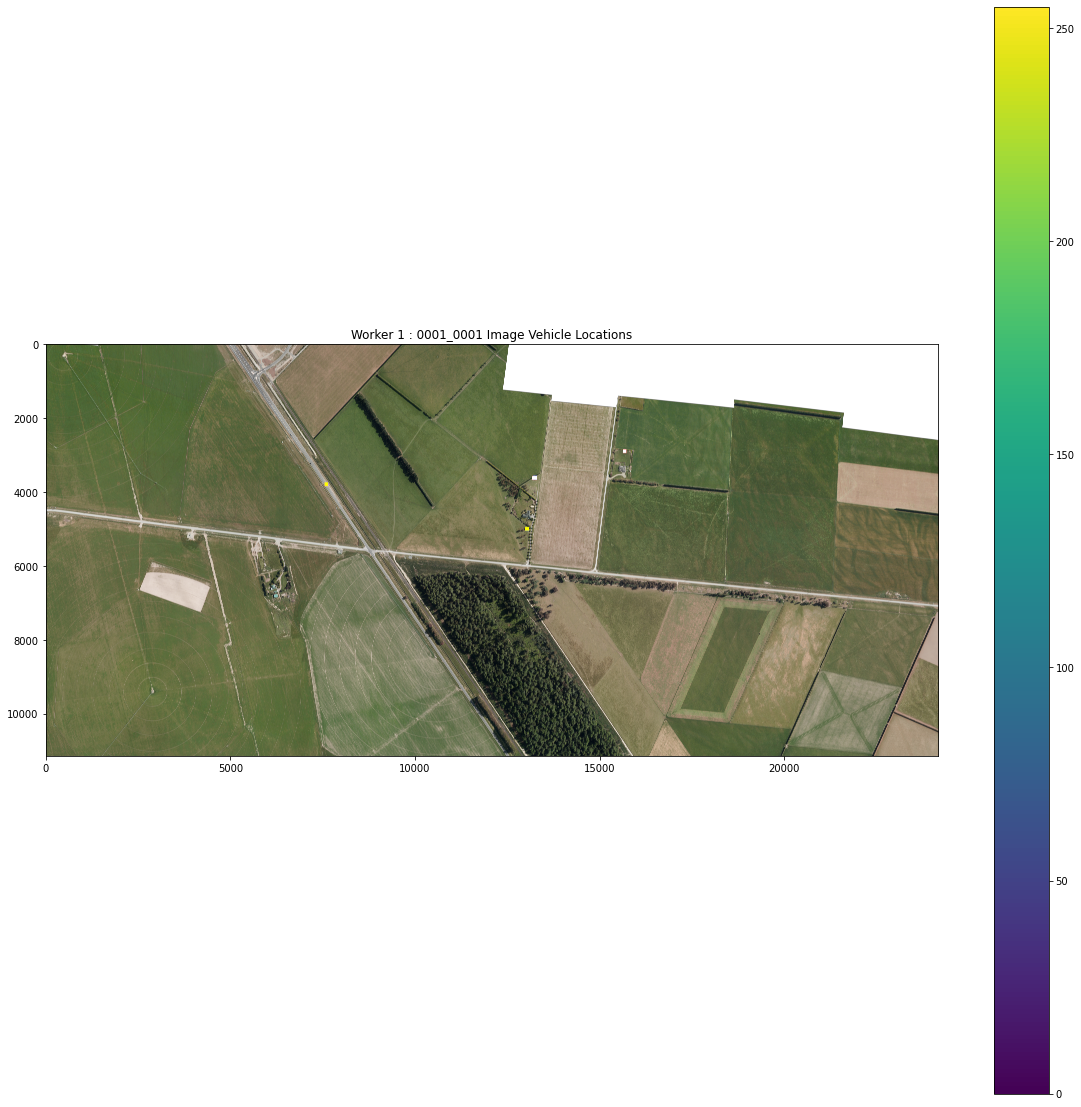

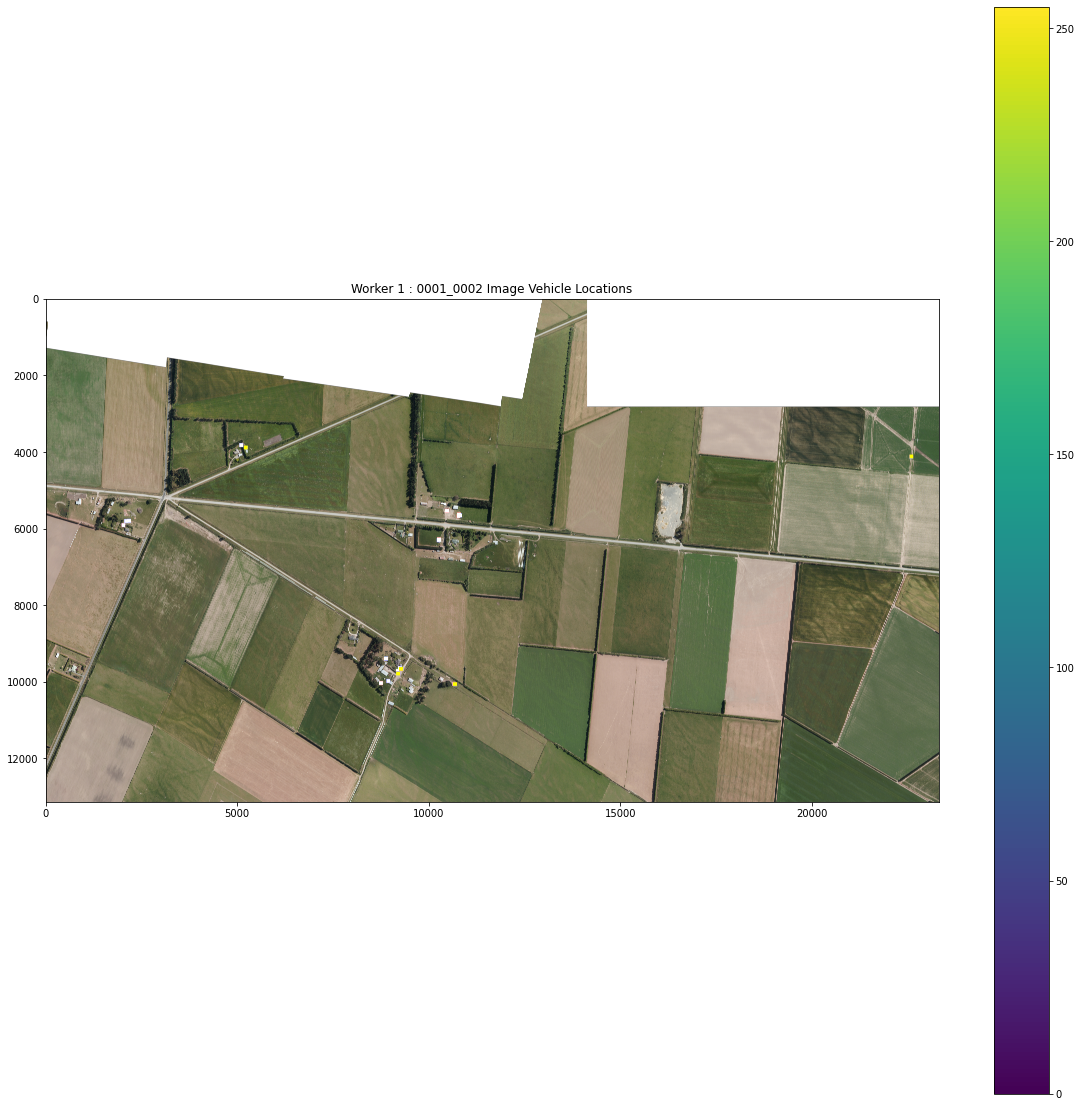

In [24]:
img1 = image1.copy()
draw1 = ImageDraw.Draw(img1)
img2 = image2.copy()
draw2 = ImageDraw.Draw(img2)
colors = [(255,0,0,0),(0,255,0,0),(0,0,255,0),(202, 44, 146,0),(255,255,0)]
count = 0
for worker in workers:
    worker_answers = submitted_answers.loc[submitted_answers['WorkerId'] == worker]
    index = worker_answers.index[0]
    tot_vehicles = 0
    ans = worker_answers['Answer.taskAnswers'][index]
    ans = json.loads(ans)#.replace("[","").replace("]",""))
    for k,v in ans[0].items():
        if k != "feedback" :
            more_points = 0
            foldername, filename = k.split("/")[6:]
            x,y = filename.split(".")[0].split("-")[2:]
            x,y = int(x),int(y)
            xy_answers = [[int(pt['x']),int(pt['y'])] for pt in v["keypoints"]]

            for pt in xy_answers:
                j,i = pt[1]+y, pt[0]+x

                ij = np.array([j,i])
                np.random.seed(2018)
                local_sum = []
                radius = radii[class_name]
                rad.append(radius)
                #print(radii[class_name],ij,ij.tolist())
                if foldername == "0001_0001":
                    row, col = ij.tolist()
                    size = class_sizes[class_name]//2
                    draw1.rectangle(( col-size,row-size,  col+size,row+size,),fill=colors[count], width=19)
                else:
                    row, col = ij.tolist()
                    size = class_sizes[class_name]//2
                    draw2.rectangle(( col-size,row-size,  col+size,row+size,),fill=colors[count], width=19)
    count += 1
    
img1.convert('RGB').save("all_workers_0001_0001_locations.png")
plt.figure(figsize=(20, 20))
plt.imshow(np.asarray(img1))
plt.title("Worker 1 : 0001_0001 Image Vehicle Locations")
plt.colorbar()
img2.convert('RGB').save("all_workers_0001_0002_locations.png")
plt.figure(figsize=(20, 20))
plt.imshow(np.asarray(img2))
plt.title("Worker 1 : 0001_0002 Image Vehicle Locations")
plt.colorbar()

8 [ 5005 13029] [5005, 13029]
8 [3793 7592] [3793, 7592]
8 [ 6295 10252] [6295, 10252]
8 [ 5649 10811] [5649, 10811]
8 [10060 10682] [10060, 10682]
8 [5792 2172] [5792, 2172]
8 [5797 2098] [5797, 2098]
8 [ 4119 22594] [4119, 22594]
8 [3879 5217] [3879, 5217]
8 [3814 5101] [3814, 5101]
8 [9387 8881] [9387, 8881]
8 [9709 9188] [9709, 9188]
8 [9658 9268] [9658, 9268]
8 [9771 9200] [9771, 9200]


Text(0.5, 1.0, 'Worker 2 : 0001_0002 Image Vehicle Locations')

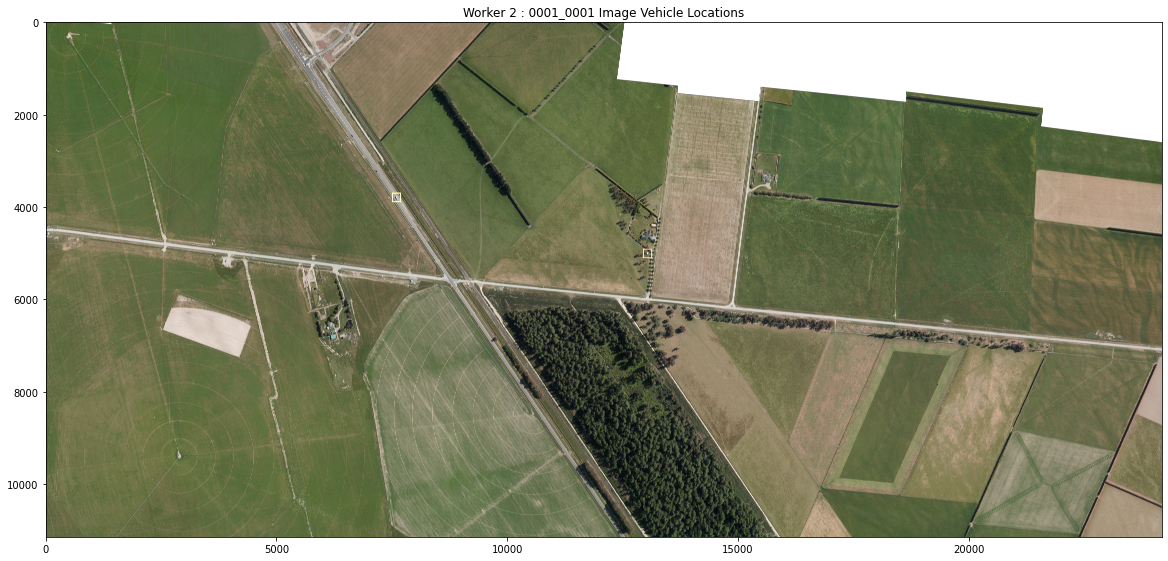

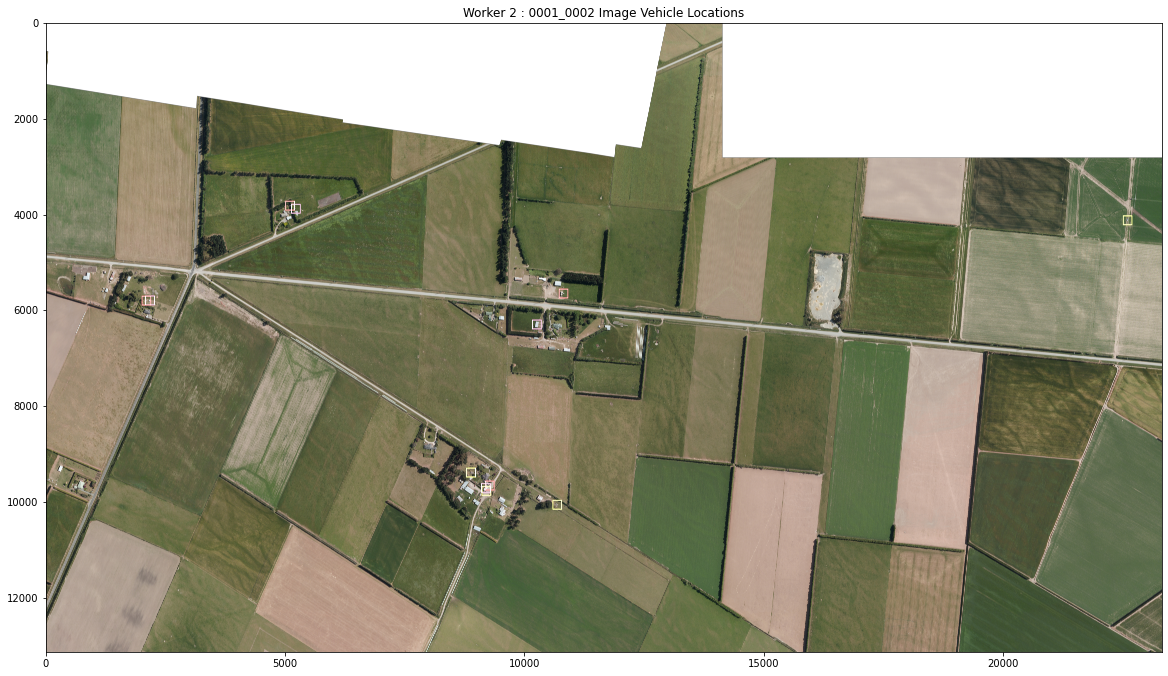

In [25]:
worker_answers = submitted_answers.loc[submitted_answers['WorkerId'] == workers[1]]

index = worker_answers.index[0]
img1 = image1.copy()
draw1 = ImageDraw.Draw(img1)
img2 = image2.copy()
draw2 = ImageDraw.Draw(img2)

worker_answers = submitted_answers.loc[submitted_answers['WorkerId'] == workers[1]]
index = worker_answers.index[0]
tot_vehicles = 0

ans = worker_answers['Answer.taskAnswers'][index]
ans = json.loads(ans)#.replace("[","").replace("]",""))
for k,v in ans[0].items():
    if k != "feedback" :
        more_points = 0
        foldername, filename = k.split("/")[6:]
        x,y = filename.split(".")[0].split("-")[2:]
        x,y = int(x),int(y)
        xy_answers = [[int(pt['x']),int(pt['y'])] for pt in v["keypoints"]]

        for pt in xy_answers:
            j,i = pt[1]+y, pt[0]+x

            ij = np.array([j,i])
            np.random.seed(2018)
            local_sum = []
            radius = radii[class_name]
            rad.append(radius)
            print(radii[class_name],ij,ij.tolist())
            if foldername == "0001_0001":
                row, col = ij.tolist()
                size = class_sizes[class_name]//2
                draw1.rectangle(( col-100,row-100,  col+100,row+100,),outline=next(cols), width=17)
            else:
                row, col = ij.tolist()
                size = class_sizes[class_name]//2
                draw2.rectangle(( col-100,row-100,  col+100,row+100,),outline=next(cols), width=17)
img1.convert('RGB').save(workers[1]+"_0001_0001_locations.png")
plt.figure(figsize=(20, 20))
plt.imshow(np.asarray(img1))
plt.title("Worker 2 : 0001_0001 Image Vehicle Locations")
img2.convert('RGB').save(workers[1]+"_0001_0002_locations.png")
plt.figure(figsize=(20, 20))
plt.imshow(np.asarray(img2))
plt.title("Worker 2 : 0001_0002 Image Vehicle Locations")


8 [ 5005 13029] [5005, 13029]
8 [3793 7592] [3793, 7592]
8 [ 6295 10252] [6295, 10252]
8 [ 5649 10811] [5649, 10811]
8 [10060 10682] [10060, 10682]
8 [5792 2172] [5792, 2172]
8 [5797 2098] [5797, 2098]
8 [ 4119 22594] [4119, 22594]
8 [3879 5217] [3879, 5217]
8 [3814 5101] [3814, 5101]
8 [9387 8881] [9387, 8881]
8 [9709 9188] [9709, 9188]
8 [9658 9268] [9658, 9268]
8 [9771 9200] [9771, 9200]


Text(0.5, 1.0, 'Worker 2 : 0001_0002 Image Vehicle Locations')

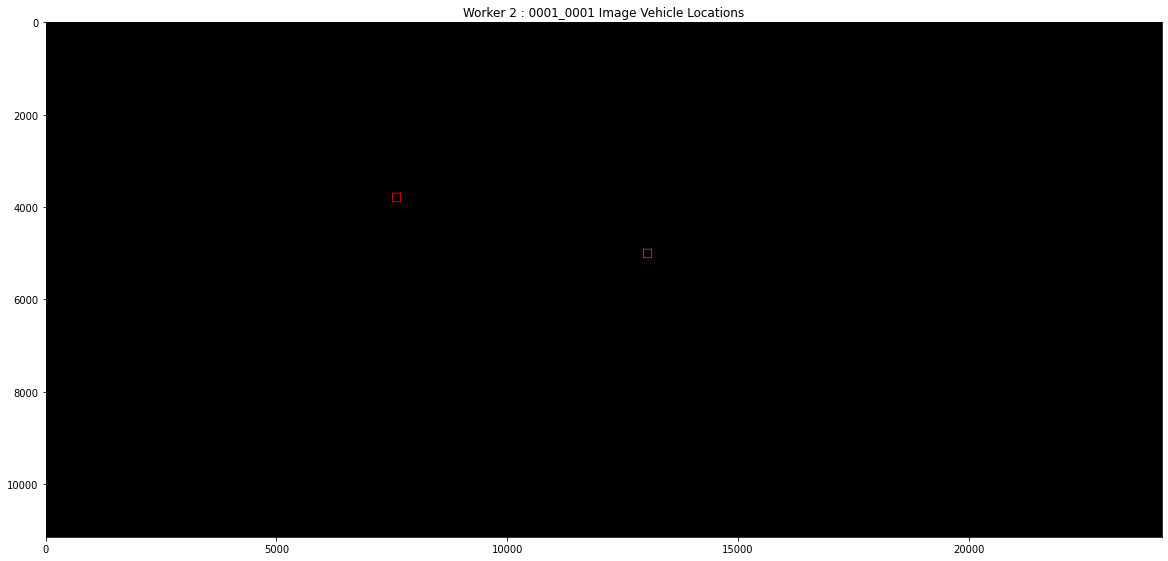

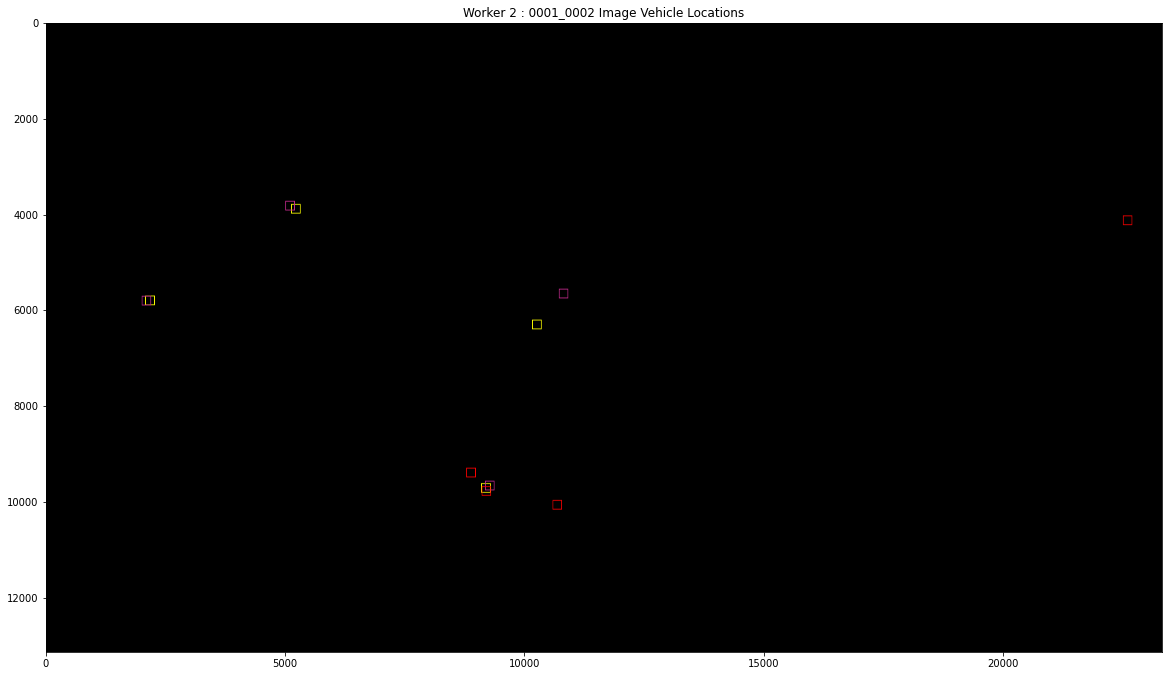

In [26]:
worker_answers = submitted_answers.loc[submitted_answers['WorkerId'] == workers[1]]

index = worker_answers.index[0]
img1 = Image.new("RGB", (24174, 11141), (0, 0, 0))
draw1 = ImageDraw.Draw(img1)
img2 = Image.new("RGB", (23314,13134), (0, 0, 0))
draw2 = ImageDraw.Draw(img2)

worker_answers = submitted_answers.loc[submitted_answers['WorkerId'] == workers[1]]
index = worker_answers.index[0]
tot_vehicles = 0

ans = worker_answers['Answer.taskAnswers'][index]
ans = json.loads(ans)#.replace("[","").replace("]",""))
for k,v in ans[0].items():
    if k != "feedback" :
        more_points = 0
        foldername, filename = k.split("/")[6:]
        x,y = filename.split(".")[0].split("-")[2:]
        x,y = int(x),int(y)
        xy_answers = [[int(pt['x']),int(pt['y'])] for pt in v["keypoints"]]

        for pt in xy_answers:
            j,i = pt[1]+y, pt[0]+x

            ij = np.array([j,i])
            np.random.seed(2018)
            local_sum = []
            radius = radii[class_name]
            rad.append(radius)
            print(radii[class_name],ij,ij.tolist())
            if foldername == "0001_0001":
                row, col = ij.tolist()
                size = class_sizes[class_name]//2
                draw1.rectangle(( col-100,row-100,  col+100,row+100,),outline=next(cols), width=17)
            else:
                row, col = ij.tolist()
                size = class_sizes[class_name]//2
                draw2.rectangle(( col-100,row-100,  col+100,row+100,),outline=next(cols), width=17)
img1.convert('RGB').save(workers[1]+"_0001_0001_locations.png")
plt.figure(figsize=(20, 20))
plt.imshow(np.asarray(img1))
plt.title("Worker 2 : 0001_0001 Image Vehicle Locations")
img2.convert('RGB').save(workers[1]+"_0001_0002_locations.png")
plt.figure(figsize=(20, 20))
plt.imshow(np.asarray(img2))
plt.title("Worker 2 : 0001_0002 Image Vehicle Locations")
